In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import os
import io
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models

In [76]:
def sinus(a,w,x,b):
    return a*np.sin(w*x)+b

def quad(a,b,c,x):
    return a*x**2 + b*x + c

In [3]:
x = np.arange(200)/10.0 - 10

In [4]:
y = sinus(1,1,x,1)

In [192]:
def examples_create(num):
    dataset = pd.DataFrame(columns=['picture', 'num'])
    
    for i in tqdm(range(num)):
        n = int(np.random.random(1)*6)+2

        fig = plt.figure(figsize=(4, 4), dpi=32)
#         flag = int(np.random.random(1)*2)
        for i in range(n):

            
#             if flag:
            y = sinus(np.random.random(1)*5, np.random.random(1)*5, x, np.random.random(1)*50-25)
#             else:
            y = quad(np.random.random(1)*5-2.5, np.random.random(1)*5, np.random.random(1)*20, x)

            plt.plot(x,y)

        io_buf = io.BytesIO()
        fig.savefig(io_buf, format='raw', dpi=32)
        io_buf.seek(0)
        img_arr = np.reshape(np.frombuffer(io_buf.getvalue(), dtype=np.uint8),
                             newshape=(int(fig.bbox.bounds[3]), int(fig.bbox.bounds[2]), -1))
        io_buf.close()
        plt.close()
        
        dataset.loc[-1] = [img_arr, n]
        dataset.index += 1
#     dataset = dataset.sort_index()
    return dataset

In [78]:
dataset = examples_create(3000)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:59<00:00, 25.20it/s]


In [79]:
dataset.to_pickle('funcset_test.pkl')

In [80]:
data = pd.read_pickle('funcset_dif.pkl')
data = data.sample(frac=1)
data = data.reset_index(drop=True)

In [82]:
full_size = len(data)
train_size = 2600

In [83]:
y_train = data.iloc[:train_size, 1]-1
y_train = np.array(y_train).astype('uint8').reshape(train_size,1)

In [84]:
x_train = np.concatenate(([data.iloc[0,0]], [data.iloc[1,0]]), axis=0)

for i in range(train_size-2):
    x_train = np.concatenate((x_train, [data.iloc[i+2,0]]), axis=0)

In [85]:
y_val = data.iloc[train_size:, 1]-1
y_val = np.array(y_val).astype('uint8').reshape(full_size-train_size,1)

In [86]:
x_val = np.concatenate(([data.iloc[train_size,0]], [data.iloc[train_size+1,0]]), axis=0)

for i in range(full_size-train_size-2):
    x_val = np.concatenate((x_val, [data.iloc[i+train_size+2,0]]), axis=0)

In [266]:
model = models.Sequential()
model.add(layers.Conv2D(8, (3, 3), activation='relu', input_shape=(128, 128, 4)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

In [267]:
model.summary()

Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_204 (Conv2D)         (None, 126, 126, 8)       296       
                                                                 
 max_pooling2d_198 (MaxPooli  (None, 63, 63, 8)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_255 (Ba  (None, 63, 63, 8)        32        
 tchNormalization)                                               
                                                                 
 conv2d_205 (Conv2D)         (None, 61, 61, 16)        1168      
                                                                 
 max_pooling2d_199 (MaxPooli  (None, 30, 30, 16)       0         
 ng2D)                                                           
                                                     

In [270]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(x_train, y_train, batch_size=20, epochs=20, steps_per_epoch=100, 
                    validation_data=(x_val, y_val))

Epoch 1/20
100/100 [==============================] - 13s 108ms/step - loss: 0.1178 - accuracy: 0.9560 - val_loss: 0.8182 - val_accuracy: 0.7900
Epoch 2/20
100/100 [==============================] - 11s 105ms/step - loss: 0.0613 - accuracy: 0.9790 - val_loss: 2.3822 - val_accuracy: 0.5600
Epoch 3/20
100/100 [==============================] - 11s 106ms/step - loss: 0.0848 - accuracy: 0.9715 - val_loss: 2.8154 - val_accuracy: 0.4475
Epoch 4/20
100/100 [==============================] - 10s 105ms/step - loss: 0.1157 - accuracy: 0.9635 - val_loss: 4.0696 - val_accuracy: 0.3550
Epoch 5/20
100/100 [==============================] - 10s 105ms/step - loss: 0.0982 - accuracy: 0.9690 - val_loss: 1.8876 - val_accuracy: 0.6200
Epoch 6/20
100/100 [==============================] - 10s 105ms/step - loss: 0.0598 - accuracy: 0.9785 - val_loss: 6.7645 - val_accuracy: 0.1575
Epoch 7/20
100/100 [==============================] - 11s 105ms/step - loss: 0.0863 - accuracy: 0.9700 - val_loss: 0.9833 - val_ac

13/13 - 1s - loss: 1.4185 - accuracy: 0.7650 - 575ms/epoch - 44ms/step


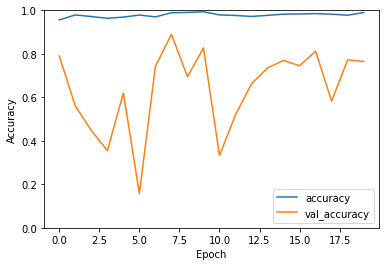

In [271]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(x_val,  y_val, verbose=2)

In [95]:
print(test_acc)

0.7099999785423279
